# 1.  Import des données 

In [1]:
import csv
import numpy as np
%matplotlib inline
# pour ipyhton notebook 
import matplotlib as plt
import pylab as pl

In [2]:
with open('u.info', 'r') as f:
    reader = csv.reader(f, delimiter = '\n')
    Info = list(reader)
print(Info)

[['943 users'], ['1682 items'], ['100000 ratings']]


## Création de deux fonctions utiles pour importer les fichiers

In [3]:
def open_numeric(baseFileName, fieldnames=['user','movie','rating','datestamp'], delimiter='\t'):
    """
    fonction généralisée pour lire les fichiers numériques
    """
    with open(baseFileName, 'r') as f:
         reader = csv.DictReader(f, delimiter = delimiter, fieldnames=fieldnames)
         # create a dict out of reader, converting all values to integers
         return [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]


In [4]:
def open_file(baseFileName, fieldnames=None , delimiter='|'):    
    """
    fonction généralisée pour lire les fichiers non numériques
    """   
    with open(baseFileName, 'r') as f:
         reader = csv.DictReader(f, delimiter = delimiter,fieldnames=fieldnames)
         return list(reader)

 ##  Création des deux directionnaires des ratings (20% et 80%)

In [5]:
baseUserItem=open_numeric("u1.base")

In [6]:
testUserItem=open_numeric("u1.test")


## Informations sur les User / Occupation /Items (movies) / Genres 

In [7]:
User=open_file("u.user", fieldnames=['userID','age','gender','occupation','zipcode'])


In [8]:
with open('u.occupation', 'r') as f: #je n'ai pas réussi a utiliser la fonction généralisée, la doc de csv.reader n'est pas à jour
    reader = csv.reader(f)
    Occupation = list(reader)


In [9]:
Item = open_file("u.item", fieldnames=['movieID', 'Title', 'releaseDate', 'videoReleaseDate','IMDb URL', 'unknown',
                                       'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
                                       'Drama','Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery','Romance', 
                                       'Sci-Fi', 'Thriller', 'War', 'Western'])



In [10]:
Genre=open_file("u.genre",fieldnames=['Genre:','Numero:'])


## 2.  Création de la matrice R (M x N) qui contient les notes des films Ni noté par le user Mi (ou 0 si film non noté)

M = nombre de users ; 
N = nb de films

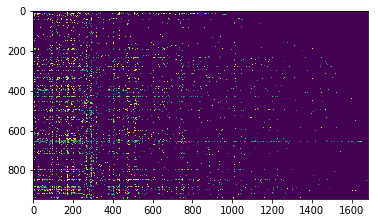

In [11]:
# Remplir la matrice utilisateur-item 
NbUsers = len(User)
NbItems= len(Item)
R = np.zeros((NbUsers, NbItems))
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']
pl.imshow(R,interpolation='none')

In [12]:
print(R.shape)

(943, 1682)


# 3.   Approximation bas-rang par SVD

 ## Remplissage matrice RC (note moyenne film)


In [13]:
mean_items=[0 for row in range(NbItems)] #liste des moyenne par colonne(film)
for col in range(NbItems):
   rating_number=0 #savoir le nombre d'éléments quon additionne pour diviser la moyenne 
   for user_rating in R[:,col]:
       if user_rating!=0: # on ne prend que les valeurs non nul
           mean_items[col]+=user_rating
           rating_number+=1
   if rating_number!=0: #il doit y avoir au moins une note par film
       mean_items[col]=mean_items[col]/rating_number  

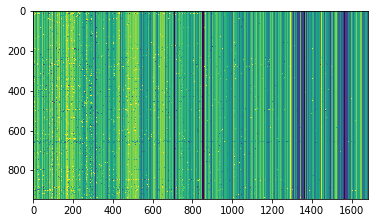

In [14]:
RC=R.copy() #matrice remplie par note moyenne film

for col in range(NbItems):
    for row in range(NbUsers):
        if RC[row, col]==0:
            RC[row, col]=mean_items[col]
            
pl.imshow(RC,interpolation='none')

 ## Remplissage matrice RR  (note moyenne user)


In [15]:
mean_users=[0 for row in range(NbUsers)] #liste des moyenne par lignes(users)
for row in range(NbUsers):
   rating_number=0 #savoir le nombre d'éléments quon additionne pour diviser la moyenne
   for user_rating in R[row,:]:
       if user_rating!=0:
           mean_users[row]+=user_rating
           rating_number+=1
   if rating_number!=0:    #il doit y avoir au moins une note par film   
       mean_users[row]=mean_users[row]/rating_number      

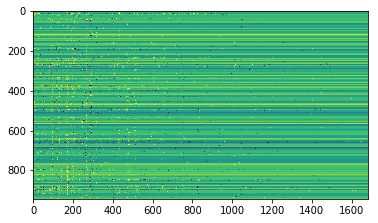

In [16]:
RR=R.copy() #matrice remplie par note moyenne user

for row in range(NbUsers):
    for col in range(NbItems):
        if RR[row, col]==0:
            RR[row, col]=mean_users[row]

pl.imshow(RR,interpolation='none') 

## Décomposition en valeurs singulières des matrices RR et RC

In [17]:
def svd_matrice(A):
    """ 
    A : matrice de taille MxN (ici M < N)
    Fonction qui réalise la décomposition en valeurs singulières de A tq : A = U x Sigma x VT
    Retourne :
    U : matrice de taille MxM unitaire
    Sigma : matrice  diagonal de taille MxN 
    VT : Transpose de la matrice V qui est de taille NxN unitaire
    """
    U, s, VT = np.linalg.svd(A, full_matrices=True)   # s est un vecteur de taille M (M < N) contenant les coeffs 
    S = np.zeros((A.shape[0], A.shape[1])) # on créé S une matrice de taille M x N
    m = min(A.shape[0], A.shape[1]) # ici M < N donc on aura m = M
    S[:m, :m] = np.diag(s) # On rempli S par la matrice carre diagonale MxM contenant les coeffs
    return U, S, VT
    
    

Calcul de Uc, Sc, VTc tq : RC = Uc x Sc x VTc


In [18]:
Uc, Sc, VTc = svd_matrice(RC)
print(Uc.shape)
print(Sc.shape)
print(VTc.shape)
print("A-t-on bien RC = Uc x Sc x VTc : ", np.allclose(RC, np.dot(Uc, np.dot(Sc, VTc))))

(943, 943)
(943, 1682)
(1682, 1682)
A-t-on bien RC = Uc x Sc x VTc :  True


Calcul de Ur, Sr, VTr tq : RR = Ur x Sr x VTr

In [19]:
Ur, Sr, VTr = svd_matrice(RR)
print(Ur.shape)
print(Sr.shape)
print(VTr.shape)
print("A-t-on bien RR = Ur x Sr x VTr : ", np.allclose(RR, np.dot(Ur, np.dot(Sr, VTr))))

(943, 943)
(943, 1682)
(1682, 1682)
A-t-on bien RR = Ur x Sr x VTr :  True


Calcul de RRk et RCk les approximations bas-rang UkSkV′k des matrices RR et RC : 

In [20]:
liste_Srk = []
liste_Urk = []
liste_VTrk = []
liste_RRk = []
for k in range(1,31):
    Srk = Sr[:k, :k]  #on remplie SS (matrice diagonale remplie des k premiers coeffs) 
      # matrice de rang k
    liste_Srk.append(Srk)
    Urk = Ur[:,:k]
    VTrk = VTr[:k,:]
    RRk = np.dot(Urk,np.dot(Srk,VTrk))
    liste_Urk.append(Urk)
    liste_VTrk.append(VTrk)
    liste_RRk.append(RRk)


In [21]:
liste_Sck = []
liste_Uck = []
liste_VTck = []
liste_RCk = []
for k in range(1,31):
    Sck = Sr[:k, :k]  #on remplie Sck (matrice diagonale remplie des k premiers coeffs) 
    liste_Sck.append(Sck)
      # matrice de rang k
    Uck = Uc[:,:k]
    VTck = VTc[:k,:]
    RCk = np.dot(Uck,np.dot(Sck,VTck))
    liste_Uck.append(Uck)
    liste_VTck.append(VTck)
    liste_RCk.append(RCk)


# 4. Qualité de la prédiction par SVD #

## Calcul des MAE pour RCk et RRk pour k=1,...30 ##

_Liste des matrices de prédictions RC pour k allant de 1 à 30 :_

In [22]:
liste_matrices_predictions_RC = []
for k in range (0,len(liste_Sck)):
    matrice_predictions_RC = np.dot(liste_Uck[k], np.dot(liste_Sck[k], liste_VTck[k]))
    liste_matrices_predictions_RC.append(matrice_predictions_RC)

_Liste des matrices de prédictions RR pour k allant de 1 à 30 :_

In [23]:
liste_matrices_predictions_RR = []
for k in range (0,20):
    matrice_predictions_RR = np.dot(liste_Urk[k], np.dot(liste_Srk[k], liste_VTrk[k]))
    liste_matrices_predictions_RR.append(matrice_predictions_RR)

_On retrouve bien la même chose !!!!!!!!!!!!!!_

In [24]:
NbUsers = len(User)
NbItems= len(Item)
Rtest = np.zeros((NbUsers, NbItems))
for row in testUserItem:
    Rtest[row['user']-1,row['movie']-1] = row['rating']

In [29]:
liste_MAEc = []
for k in range(0,30):
    errorRating = []
    for i in range(0,Rtest.shape[0]):
        for j in range(0,Rtest.shape[1]):
            if Rtest[i][j] != 0:
                errorRating.append(liste_matrices_predictions_RC[k][i][j]-Rtest[i][j])
    liste_MAEc.append(np.mean(np.abs(errorRating)))

print(liste_MAEc) 


[0.8755626528476183, 0.8664944647850105, 0.8676464784656093, 0.8648093568273458, 0.8631411597777001, 0.8619107560120148, 0.8611054412810321, 0.8606151633758613, 0.8608546374610815, 0.8603667899253087, 0.8601301391139503, 0.860355770913315, 0.8601724309504787, 0.8603689779789604, 0.8604841813281874, 0.8607054444533127, 0.8606621536649717, 0.860958730799719, 0.8613370888454032, 0.8611876139121066, 0.8614080304088421, 0.861392516392809, 0.8615927023761096, 0.8614301597406898, 0.8618318099175005, 0.8623542407524466, 0.8631075560101493, 0.8631855882948412, 0.8631736761567056, 0.8637757297657096]


In [33]:
liste_MAEr = []
for k in range(0,20):
    errorRating = []
    for i in range(0,Rtest.shape[0]):
        for j in range(0,Rtest.shape[1]):
            if Rtest[i][j] != 0:
                errorRating.append(liste_matrices_predictions_RR[k][i][j]-Rtest[i][j])
    liste_MAEr.append(np.mean(np.abs(errorRating)))

print(liste_MAEr) 

[0.8326768692021651, 0.8211064444122338, 0.8120213134397177, 0.8111105452391719, 0.8087415447159854, 0.8081383533467984, 0.8061760029475273, 0.8051129430430015, 0.8052048904261178, 0.8052520355623543, 0.8056244360281737, 0.805172671236107, 0.8050435806418521, 0.8050184584915536, 0.8049808085027975, 0.8052217080662878, 0.8049271515519609, 0.8049848542235917, 0.8052379530650762, 0.805884106762133]
